In [1]:
import sys
print(sys.executable)

/Users/schellma/miniconda/envs/rootenv/bin/python


In [2]:
# code to generate yearly summaries of DUNE data volumes from input parameters
# rewritten from the version in the CDR - mainly by using maps of years instead of arrays to make it clearer what is in each year.
# HMS 2022-10-23

# if you have json problems, run the program ../strip.py on your file to take off comments
# and then test using https://jsonlint.com
#import numberutils

import os,sys,string,time,commentjson,datetime, math
import json
import nbconvert
from csv import reader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

DEBUG = False
DRAW = True
import numpy as np
import scipy
import dunestyle.matplotlib as dunestyle

from NumberUtils import dump
from NumberUtils import DrawTex
from NumberUtils import cumulateMap
from NumberUtils import DrawDet
from NumberUtils import DrawType
from NumberUtils import makeArray
from NumberUtils import ToCSV1
from NumberUtils import ToCSV2
from NumberUtils import SumOver1
from NumberUtils import SumOver2
from NumberUtils import TableTex
from NumberUtils import DrawTex
from NumberUtils import BothTex
from NumberUtils import extendMap
from NumberUtils import makeParameter

from DataHolder import DataHolder


DUNE plot style enabled


In [3]:
# how many histograms to draw in multi-hist plots
N_HISTS = 8   # exhibits all the colors in the Okabe-Ito cycler


# specify the json file here.  Will create a subdirectory for plots with a similar name

## 

"Tex"# read in a configfile
#configfilename = "Parameters_2022-11-21-2040.json"

#configfilename = "DOE23-NDLAr_2023-11-03-2040b.json"
#configfilename = "DOE23-NDLAr_2023-12-11-2040.json"  # increase sim for ND

In [4]:
configfilename = "NearTerm_2024-06-12-2040.json"
#if len(sys.argv) > 1:
#  configfile = sys.argv[1]

shortname = configfilename.replace(".json","")
if os.path.exists(configfilename):
  with open(configfilename,'r') as f:
    #x = f.read()
    #print (x[6000:6960])
    config = commentjson.load(f)
else:
  print ("no config file",configfilename)
  sys.exit(0)

if not "Version" in config or config["Version"] < 5:
  print (" this code expects Version >= 2")
  sys.exit(1)



# read in the config parameters 

In [5]:
MWCWeight = config["MWCWeight"] # do we weight cores by available memory? 
MaxYear = config["MaxYear"]
MWCstring = "_noMWC"
if MWCWeight: MWCstring=""
#config["filename"] = configfilename.replace("_","\_")
config["filename"] = configfilename
MinYear = config["MinYear"]
Detectors = config["Detectors"]
if DEBUG:
  Detectors = ["SP","PDHD","DP"]
#HMS Years = np.array(config["Years"])
Years = config["Years"]
#if DEBUG:
#  Years = Years[0:7]


shortname = shortname.replace("2040","%d"%MaxYear)+MWCstring
dirname = shortname
if not os.path.exists(dirname):
    os.mkdir(dirname)
shortname = dirname+"/"+dirname
# make a tex output file
texfilename = dirname+".tex"
texfile = open(texfilename,'w')
tablefile = open(os.path.join(dirname,"tables.tex"),'w')

size = len(Years)

Units = config["Units"]

RequestYear=2024
if "RequestYear" in config:
    RequestYear= config["RequestYear"]

if not MWCWeight: 
    print ("remove MWC")
    for type in Units.keys():
        Units[type] = Units[type].replace("MWC-","")
        Units[type] = Units[type].replace("Memory weighted ","")
        Units[type] = Units[type].replace("Memory Weighted ","")
    print ("Units", Units)
        
Formats = config["Formats"]

Detectors = config["Detectors"]
DataTypes = config["DataTypes"]
NativeTypes = config["NativeTypes"]
Resources = config["Resources"]
Locations = config["Locations"]

Cap = config["Cap"]

BaseMemory = config["Base-Memory"]

print (Detectors)

CombinedDetectors = config["CombinedDetectors"]

DetectorParameters = list(config["SP"].keys())

if "Comment" in DetectorParameters:
    DetectorParameters.remove("Comment")

TapeLifetimes = config["TapeLifetimes"]

DiskLifetimes = config["DiskLifetimes"]

TapeCopies = config["TapeCopies"]

DiskCopies = config["DiskCopies"]

# this is how far you go back each time you reprocess reco.
Reprocess = config["Reprocess"]

AnalysisExtend = config["AnalysisExtend"]

PerYear = config["PerYear"]

StorageTypes = list(TapeCopies.keys())

print (StorageTypes)

DetColors=config["DetColors"]
DetLines = config["DetLines"]
TypeColors=config["TypeColors"]
TypeLines = config["TypeLines"]

PatternFraction = config["PatternFraction"]

SplitsYear = config["SplitsYear"]
SplitsEarly = config["SplitsEarly"]
SplitsLater = config["SplitsLater"]

Explain = config["Explain"]
Explain["filename"] = "Input configuration file"

diskactual = config["Actual"]["diskactual"]
tapeactual = config["Actual"]["tapeactual"]
wallactual = config["Actual"]["wallactual"]
efficiency = config["Cores"]["Efficiency"]

remove MWC
Units {'Events': 'Million', 'Raw-Store': 'PB', 'Test': 'PB', 'Raw+Test': 'PB', 'Reco-Data-Store': 'PB', 'Reco-Data-CPU': 'CPU MHrs', 'Sim-Events': 'M', 'Sim-Store': 'PB', 'Sim-CPU': 'CPU MHrs', 'Analysis-CPU': 'CPU MHrs', 'All': 'PB', 'Years': '', 'Total-CPU': 'CPU MHrs', 'Cumulative-Tape': 'PB', 'Cumulative-Disk': 'PB', 'Tape': 'PB', 'Disk': 'PB', 'Cores': '2020-vintage MWC Cores', 'HS23': 'kHS23-yrs', 'Wall': 'Wall MHrs', 'HPC-Storage': 'PB', 'HPC-CPU': 'CPU MHrs', 'Reco-Data-GPU': 'GPU MHrs', 'Sim-GPU': 'GPU MHrs', 'Store': 'PB', 'CPU': 'CPU MHrs', 'GPU': 'GPU MHrs'}
['SP', 'PDHD', 'DP', 'PDVD', 'HD', 'VD', 'ND-SAND', 'ND-LAr+TMS']
['Raw-Store', 'Test', 'Reco-Data-Store', 'Sim-Store']


# Output some text that explains your parameters

In [6]:
for f in Explain.keys():

    field = "{\\tt %s:} %s = {\\tt %s} \\\\\n"%(f,Explain[f], config[f])
    field = field.replace("_","\_")
    tablefile.write(field)
    print (Explain[f])

Detectors included in the calculation
Cap on Raw data per year in PB
MB of memory per slot assumed as the average
Plot until year
Plot starting with year
Number of years of data reprocessed when doing a new pass
Years analysis continues after last reco/sim
Fraction of time taken in pattern recognition
Number of years kept on tape
Number of years kept on disk
Number of copies kept on tape
Number of copies kept on disk
Number of reprocessing done per year
Description of cores, efficiency and speed relative to 2020 vintage
kHEPSPEC06 per core assumed
Year CERN no longer responsible for disk or tape
Division between FNAL/CERN/Global for storage until SplitsYear
Division between FNAL/CERN/Global for storage after SplitsYear
Input configuration file


# Change from config - which goes 0-N to real year indices = 2018...

<!-- dofirst = ["Events","Test","Sim-Events"]
print ("Detector Parameters",DetectorParameters)
# read in the raw information

Inputs = {}
timeline = open("timeline.csv",'w')
timeline.write("detector, datatype ")
for year in Years:
    timeline.write(", %d"%year)
timeline.write("\n")

for det in Detectors:
    Inputs[det]={}
    for type in dofirst:
      Inputs[det][type]={}
      if DEBUG: print (det,type,config[det][type])
      timeline.write( "%s, %s"%(det,type))
      for year in Years:
          Inputs[det][type][year] = float(config[det][type][year-Years[0]])
          timeline.write(", %f"%Inputs[det][type][year])
      timeline.write("\n")
      if DEBUG: print ("old", det,type,Inputs[det][type])
        

timeline.close() -->

# Read in from file instead

<!-- if "Timeline" in config:
    print ("Timeline from ", config["Timeline"])
    if not os.path.exists(config["Timeline"]):
        print ("timeline file ", config["Timeline"]," does not exist:")
        
    
    Inputs = {}
    counter = 0 
    with open(config["Timeline"], newline='') as csvfile:
        data = reader(csvfile)
        for row in data:
            if counter == 0: 
                counter = 1
                continue
            if DEBUG: print (row)
            det = row[0].strip()
            if det not in Inputs: 
                Inputs[det]={}
            type = row[1].strip()
            if type not in  Inputs[det]:
                Inputs[det][type]={}
            for year in Years:
                
                #print ("test",row[year - Years[0]+2])
                Inputs[det][type][year] = float(row[year - Years[0]+2])
            if DEBUG: print ("new",det,type,Inputs[det][type])
            # print (list(Inputs[det].keys()))
    csvfile.close()
            
# for det in Inputs:
#     print (list(Inputs[det].keys()))   -->

# Make the data holder and fill from Config

In [7]:
holder = DataHolder(config)

detectors ['SP', 'PDHD', 'DP', 'PDVD', 'HD', 'VD', 'ND-SAND', 'ND-LAr+TMS']
Timeline from  NearTerm_2024-06-12-2040_timeline.csv


In [8]:
print (Detectors)
print (DataTypes)
print (Resources)
print 

['SP', 'PDHD', 'DP', 'PDVD', 'HD', 'VD', 'ND-SAND', 'ND-LAr+TMS']
['Events', 'Sim-Events', 'TP', 'Sim', 'Reco-Data', 'Test', 'Analysis']
['Tape', 'Disk', 'GPU', 'CPU', 'dummy']


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

# Take the raw # of events/year and store them.  Test/TP are in TB alread so need no scaling. 

In [9]:
# store the raw data

for detector in Detectors:
    for datatype in ["Events","TP","Test"]:
        for resource in ["Store"]:
            for location in ["ALL"]:
                if holder.hasTag(detector,datatype,"dummy",location):
                    if DEBUG: holder.printByTag(holder.tag(detector,datatype,"dummy",location))
                    if datatype == "Events":
                        factor = config[detector]["Raw-Store"]
                    else:
                        factor = 1.0
                    if Units[resource] == "PB":
                        factor *= 0.001
                    newtag = holder.scale(detector,datatype,"dummy",location,{"Resources":"Store"},factor)
                    if DEBUG: holder.printByTag(newtag)
                else:
                    print ("could not find", detector,datatype,resource,location)
        
    

could not find SP TP Store ALL
could not find DP TP Store ALL
could not find ND-SAND TP Store ALL
could not find ND-LAr+TMS TP Store ALL


In [10]:
DEBUG = True

# check to see if it is above the per year limit for raw data, if so, rescale

In [11]:
newtag = holder.tag("ALL","ALL","Store","ALL")
tags = []
for detector in Detectors:
    for datatype in ["Events","TP","Test"]:
        for resource in ["Store"]:
            for location in ["ALL"]: 
                atag = holder.tag(detector,datatype,resource,location)
                tags.append(atag)
                if DEBUG: holder.printByTag(atag)
if DEBUG: print (tags)

newtag = holder.combineByTag(tags,newtag)
if DEBUG: holder.printByTag(newtag)
                
                
            
        


 SP!Events!Store!ALL {2018: 0.763, 2019: 1.358, 2020: 0.455, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
request to print nonexistent tag SP!TP!Store!ALL

 SP!Test!Store!ALL {2018: 0.157, 2019: 0.6, 2020: 0.5, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}

 PDHD!Events!Store!ALL {2018: 0.0, 2019: 0.0, 2020: 0.0, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 2.8, 2025: 0.7, 2026: 0.7, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}

 PDHD!TP!Store!ALL {2018: 0.0, 2019: 0.0, 2020: 0.0, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 1.0, 2025: 1.0, 2026: 

In [12]:
# Now do the processing and store the outputs. 

In [13]:
DEBUG = True
print ("---------------  makereco ------------------") 
for detector in Detectors:
    
    # here you need to code reconstruction effects on all resources. 

    for datatype in ["Reco-Data","Sim"]:
        if datatype == "Reco-Data":
            input = "Events"
        if datatype == "Reco-Sim":
            input = "Sim-Events"
        # Reco gets reprocessed so has a special cumulation
        for resource in ["Store"]:# ["CPU","GPU","Store"]:
            for location in ["ALL"]:
                if holder.hasTag(detector,input,"dummy",location):
                    if DEBUG: holder.printByTag(holder.tag(detector,input,"dummy",location))                 
                    factor = config[detector][datatype+"-"+resource]
                    if datatype == "Reco-Data":  # first extend reprocessing then scale for CPU time
                        period = Reprocess[detector]
                        factor = config[detector]["Reco-Data-"+resource]
                        if Units[resource] == "PB":  # change to PB as a unit
                            factor *= 0.001
                        newtag = holder.cumulateMe(detector,input,"dummy",location,{"Resources":resource,"DataTypes":"Temp"},period)
                        newtag = holder.scale(detector,"Temp",resource,location,{"Resources":resource,"DataTypes":datatype},factor)
                    else:
                        factor = config[detector]["Sim-"+resource]
                        if Units[resource] == "PB":  # change to PB as a unit
                            factor *= 0.001
                        newtag = holder.scale(detector,input,"dummy",location,{"Resources":resource,"DataTypes":datatype},factor)
                    # extend Recodata. 
                    
                    if DEBUG: print("Rescale",resource,factor,Units[resource])
                    if DEBUG: holder.printByTag(newtag)
                    if DEBUG:
                        print ("Try to extend", detector,datatype,resource,location)
                    if datatype in ["Reco-Data","Sim"]:
                        newtag = holder.extendMe(detector,datatype,resource,location,{"DataTypes":datatype},AnalysisExtend)
                    if DEBUG: holder.printByTag(newtag)


---------------  makereco ------------------

 SP!Events!dummy!ALL {2018: 10.9, 2019: 19.4, 2020: 6.5, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
Rescale Store 0.035 PB

 SP!Reco-Data!Store!ALL {2018: 0.382, 2019: 1.06, 2020: 1.288, 2021: 0.907, 2022: 0.228, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
Try to extend SP Reco-Data Store ALL

 SP!Reco-Data!Store!ALL {2018: 0.382, 2019: 1.06, 2020: 1.288, 2021: 1.288, 2022: 1.288, 2023: 1.288, 2024: 1.288, 2025: 1.288, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}

 SP!Events!dummy!ALL {2018: 10.9, 

In [14]:
d = open("dump.json",'w')
json.dump(holder.holder,d,indent=4)

<!-- # fill in other useful arrays
for det in Detectors:
    if DEBUG:print ("types",det,list(Inputs[det].keys()))
    #print ("see it", det,Inputs[det].keys())
    
    
    for key in DetectorParameters:
        #print(key,det)
        # skip the ones already done
        if key in dofirst:
          continue
        
        # sim has its own configuration
        # print ("this is the key",det,key)
        if key == "Reco-Data-CPU" and DEBUG:
            if DEBUG: print ("reco events",det,Inputs[det]["Events"])
        if key in ["Reco-Data-CPU","Reco-Data-GPU","Reco-Data-Store"]:  # if doing reco, do over previous events using memory
            Inputs[det][key] = cumulateMap(Years,Inputs[det]["Events"],Reprocess[det])
            for year in Years:
                Inputs[det][key][year] *= config[det][key]
                
#             if key == "Reco-Data-Store":
#                 print ("extend reco data",det,key,AnalysisExtend)
#                 Inputs[det][key] = extendMap(Years,Inputs[det][key],AnalysisExtend,key)
            
            if key == "Reco-Data-CPU" and MWCWeight:
                if DEBUG: print ("fix the memory",config[det]["Reco-Memory"]/BaseMemory)
                for year in Years:
                    Inputs[det][key][year] *= (config[det]["Reco-Memory"]/BaseMemory)
                if DEBUG: print ("reco-data-cpu",det, Inputs[det][key])
            continue
        
            
        if key == "Raw-Store":
            Inputs[det][key] ={}
            if DEBUG:print (det,key)
            for year in Years:
                
                if DEBUG:print (year,float(Inputs[det]["Events"][year]),(config[det][key]))
                
                Inputs[det][key][year] = float(Inputs[det]["Events"][year])*config[det][key]
            continue
            
        if key in ["Sim-Store","Sim-CPU","Sim-GPU"]:
            
            Inputs[det][key] ={}
            for year in Years:
                Inputs[det][key][year]=Inputs[det]["Sim-Events"][year]*config[det][key]
                if key == "Sim-CPU" and MWCWeight:
                    Inputs[det][key][year]*=(config[det]["Sim-Memory"]/BaseMemory)
                
            
            
            
#             if key == "Sim-Store":
#                 #print ("got here", key)
#                 Inputs[det][key] = extendMap(Years,Inputs[det][key],AnalysisExtend,key)
#             continue
            
        
  -->

# now figure out analysis which is MC + Data x some factor

In [15]:
DEBUG = True

In [16]:
datatype = "Analysis"
for detector in Detectors:
    for resource in ["CPU","GPU"]:
        for location in ["ALL"]:
            datatag = holder.tag(detector,"Reco-Data",resource,location)
            mctag = holder.tag(detector,"Sim",resource,location)
            analysistag = holder.tag(detector,"Temp",resource,location)
            tmptag = holder.combineByTag([datatag,mctag],analysistag)
            newtag = holder.scaleByTag(tmptag,{"DataTypes":datatype},config[detector]["Analysis-CPU"])
            holder.removeTag(tmptag)  # cleanup
            if DEBUG: holder.printByTag(newtag)
                            

combineByTag skipping tag SP!Reco-Data!CPU!ALL
combineByTag skipping tag SP!Sim!CPU!ALL
tag SP!Temp!CPU!ALL removed

 SP!Analysis!CPU!ALL {2018: 0.0, 2019: 0.0, 2020: 0.0, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
combineByTag skipping tag SP!Reco-Data!GPU!ALL
combineByTag skipping tag SP!Sim!GPU!ALL
tag SP!Temp!GPU!ALL removed

 SP!Analysis!GPU!ALL {2018: 0.0, 2019: 0.0, 2020: 0.0, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
combineByTag skipping tag PDHD!Reco-Data!CPU!ALL
combineByTag skipping tag PDHD!Sim!CPU!ALL
tag PDHD!Temp!CPU!ALL removed

 PDHD!Analysis!CPU!ALL {2018: 0.0, 2019: 0.0, 2020: 0.0, 2021: 0.0, 2022: 0.0, 2023: 0.0, 202

In [17]:
print (DataTypes)

['Events', 'Sim-Events', 'TP', 'Sim', 'Reco-Data', 'Test', 'Analysis']


['SP!Events!Store!ALL', 'PDHD!Events!Store!ALL', 'DP!Events!Store!ALL', 'PDVD!Events!Store!ALL', 'HD!Events!Store!ALL', 'VD!Events!Store!ALL', 'ND-SAND!Events!Store!ALL', 'ND-LAr+TMS!Events!Store!ALL']
(-1.32, 27.72) (-1.32, 33.263999999999996)


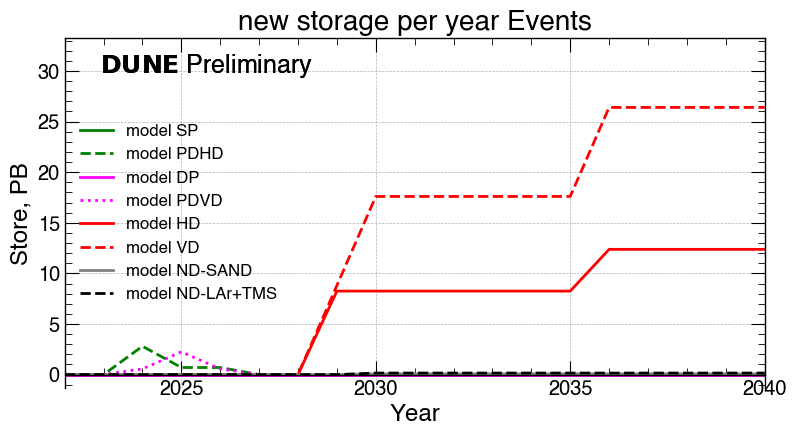

['SP!Sim!Store!ALL', 'PDHD!Sim!Store!ALL', 'DP!Sim!Store!ALL', 'PDVD!Sim!Store!ALL', 'HD!Sim!Store!ALL', 'VD!Sim!Store!ALL', 'ND-SAND!Sim!Store!ALL', 'ND-LAr+TMS!Sim!Store!ALL']
(-0.22440000000000004, 4.712400000000001) (-0.22440000000000004, 5.65488)


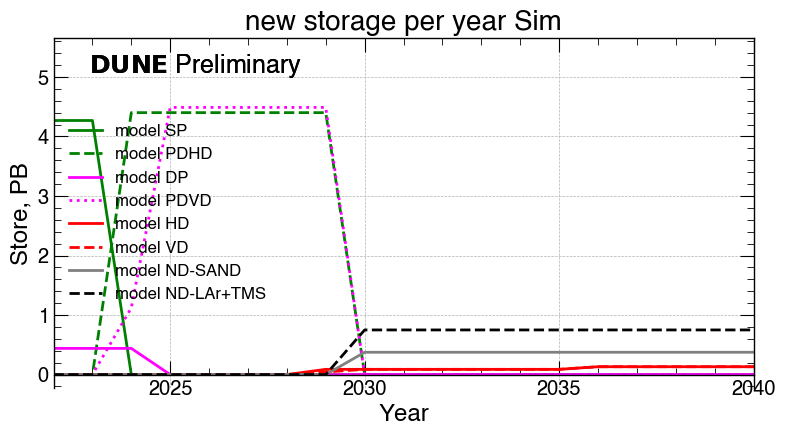

['SP!Reco-Data!Store!ALL', 'PDHD!Reco-Data!Store!ALL', 'DP!Reco-Data!Store!ALL', 'PDVD!Reco-Data!Store!ALL', 'HD!Reco-Data!Store!ALL', 'VD!Reco-Data!Store!ALL', 'ND-SAND!Reco-Data!Store!ALL', 'ND-LAr+TMS!Reco-Data!Store!ALL']
(-0.165, 3.465) (-0.165, 4.1579999999999995)


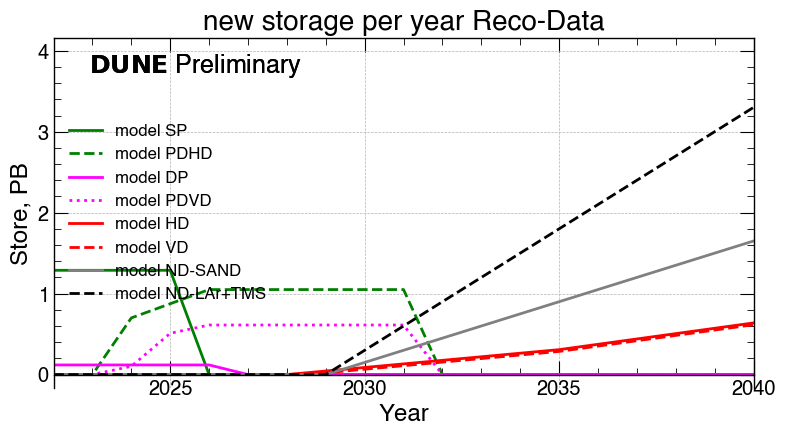

In [19]:
for datatype in ["Events","Sim","Reco-Data"]:
    tags = []
    for detector in holder.Detectors:
        tag = holder.tag(detector,datatype,"Store","ALL")
        tags.append(tag)
    print (tags)
    
    holder.Draw("new storage per year "+datatype,"Store",tags)

In [ ]:
           
            
#          # right now this uses MWC - may be ok as reading in big stuff uses memory
            
#         if key in ["Analysis-CPU"]:  # keep analyzing for a few years. 
#             data = {}
#             mc = {}
#             Inputs[det]["Analysis-CPU"] = {}
#             data  = extendMap(Years,Inputs[det]["Reco-Data-CPU"],AnalysisExtend)
#             if DEBUG: print ("data",data)
#             mc = extendMap(Years,Inputs[det]["Sim-CPU"],AnalysisExtend)
#             if DEBUG: print ("mc",mc)
#             for year in Years:
#                 total = data[year]
#                 total += mc[year]
#                 Inputs[det][key][year] = total *config[det]["Analysis-CPU"]  # this scales by a factor relative to reco/sim-MWC
           
#         if DEBUG: print ("other key",det,key)


# # do a little cleanup

# for det in Inputs.keys():
    
#     if "Sim-Memory" in Inputs[det]:
#         Inputs[det].pop("Sim-Memory")
#     if "Reco-Memory" in Inputs[det]:
#         Inputs[det].pop("Reco-Memory")

In [ ]:
# make a data file which uses # of events to figure out how big samples are

if PerYear["Reco-Data-Store"]!=PerYear["Reco-Data-CPU"]:
    print ("Data growth has to match reprocessing cycles/year")
    PerYear["Reco-Data-Store"] = PerYear["Reco-Data-CPU"]
if PerYear["Sim-Store"]!=PerYear["Sim-CPU"]:
    print ("Sim growth has to match reprocessing cycles/year")
    PerYear["Sim-Store"] = PerYear["Sim-CPU"]

In [ ]:
# Data = {}
# dump = open("dump.txt",'w')

    
# #print (Inputs.keys())
# fields = list(Inputs["ND-SAND"].keys())
# print ("fields",fields)
# for dtype in fields:
#   Data[dtype] = {}
#   if "Memory" in dtype:
#         continue
#   for det in Inputs.keys():
#     Data[dtype][det] = {}
#     # this allows you to, say, do 2 passes of reco/year
    
#     # print("makeData",dtype, det, Inputs[det][dtype][year])
#     for year in Years:
#         Data[dtype][det][year] = float(Inputs[det][dtype][year]) * float(PerYear[dtype])
#     # compensate for nominal units being millions and TB or singles and MB
#     if Units[dtype] == "PB":
#         for year in Years:
#             Data[dtype][det][year] *= 0.001
#     ds = "data %s %s %f\n"%(dtype,det,Data[dtype][det][2022])
#     dump.write(ds)

- impose a cap at Cap (30 PB/year if set)

In [ ]:
# impose a cap at Cap on things derived from raw data

dtype = "Raw-Store"

Data["Raw-Store"]["Total"] = {}
for year in Years:
        Data[dtype]["Total"][year] = 0.0
for det in Inputs.keys():

    for year in Years:
        
        Data[dtype]["Total"][year] +=  Data["Raw-Store"][det][year]
        
dtypes = ["Raw-Store"] #,"Reco-Data-CPU"]
for dtype in dtypes:
    for det in Inputs.keys():
        #print (dtype,det,2035,1.0,Data[dtype][det][2035] )
        for year in Years:
            cap = Data["Raw-Store"]["Total"][year]/Cap
           # print (dtype,det,year,cap,Data[dtype][det][year] )
            if cap > 1:
                Data[dtype][det][year] /=cap
        #print (dtype,det,2035,cap,Data[dtype][det][2035] )

# Make a total across detectors

In [ ]:



dtypes = ["Raw-Store","Reco-Data-Store","Sim-Store","Reco-Data-CPU","Sim-CPU","Analysis-CPU"]



for dtype in dtypes:
    Data[dtype]["Total"] ={}
    
        
    for year in Years:
        Data[dtype]["Total"][year] = 0.0
    for det in Inputs.keys():
        #if dtype != "Analysis":  # not certain what this does... I think it is leftover. 
        for year in Years:
               Data[dtype]["Total"][year]+=  Data[dtype][det][year] 
    
             
    

In [ ]:
PlotYears = []
for i in range(MinYear,MaxYear+1):
    PlotYears.append(i)

In [ ]:
PlotYears = []
for i in range(MinYear,MaxYear+1):
    PlotYears.append(i)
#PlotYears = Years
print ("PlotYears",PlotYears)
# draw things
things = list(Inputs.keys())+["Total"]

if DRAW:
    for stuff in ["Events","Test","Sim-Events","Raw-Store","Reco-Data-Store","Sim-Store","Reco-Data-CPU","Sim-CPU","Analysis-CPU","Reco-Data-GPU","Sim-GPU"]:
        DrawDet(shortname,stuff,PlotYears,Data,things,Units,DetColors,DetLines)

ToCSV2(shortname+"-Reco-Data-GPU","Reco-Data-GPU",PlotYears,Data,Units,Formats)
ToCSV2(shortname+"-Sim-GPU","Sim-GPU",PlotYears,Data,Units,Formats)


In [ ]:
PlotYears = []
for i in range(MinYear,MaxYear+1):
    PlotYears.append(i)
#PlotYears = Years
print ("PlotYears",PlotYears)
# draw things
things = list(Inputs.keys())+["Total"]

print (Inputs.keys())
other = list(Inputs["ND-SAND"].keys())+["Total"]

print (other)


if DRAW:
    for stuff in ["Events","Test","Sim-Events","Raw-Store","Reco-Data-Store","Sim-Store","Reco-Data-CPU","Sim-CPU","Analysis-CPU"]:
        DrawDet(shortname,stuff,PlotYears,Data,things,Units,DetColors,DetLines)



In [ ]:
# merge protodune info

if DEBUG: print ("Data keys",Data.keys())

for dtype in Data.keys():
    if DEBUG: print ("Merge protodunes",dtype)
    det = "PDs" 
    Data[dtype][det] = {}
    for year in Years:  
        Data[dtype][det][year] = Data[dtype]["SP"][year] + Data[dtype]["DP"][year] + Data[dtype]["PDHD"][year] + Data[dtype]["PDVD"][year]

    Data[dtype].pop("SP")
    Data[dtype].pop("PDHD")
    Data[dtype].pop("DP")
    Data[dtype].pop("PDVD")
    


In [ ]:
# merge far detector into "FDs
if "HD" in Detectors and "VD" in Detectors:
    for dtype in Data.keys():
        det = "FDs"
        print ("merge FDS",dtype)
        Data[dtype][det] =  {}
        for year in Years:  
            Data[dtype][det][year] = Data[dtype]["HD"][year] + Data[dtype]["VD"][year]
        Data[dtype].pop("HD")
        Data[dtype].pop("VD")
        
# for dtype in Data.keys():
#         det = "FDs"
#         Data[dtype][det] =  {}
#         for year in Years:  
#             Data[dtype][det][year] = 0
        
# for subdet in ["Calib","HighE","LowE","LBL","Calib","TP"]:
#     for dtype in Data.keys():
#         det = "FDs"
#         print ("merge FDS",dtype)
        
#         for year in Years:  
#             Data[dtype][det][year] += Data[dtype][subdet][year] 
#         Data[dtype].pop("subdet")


In [ ]:
# make a total CPU category

Data["Total-CPU"]={}

for det in CombinedDetectors:
    Data["Total-CPU"][det] =  {}
    for year in Years:
        Data["Total-CPU"][det][year] = Data["Reco-Data-CPU"][det][year] + Data["Sim-CPU"][det][year] + Data["Analysis-CPU"][det][year]
    #print(det,Data["Total-CPU"][det])

In [ ]:
# make totals across categories. 

DataTypes = list(Data.keys())

for dt in DataTypes:
    Data[dt]["Total"] = {}
    for year in Years:
        Data[dt]["Total"][year]=0.0
    for k in Data[dt].keys():
        if k == "Total":
          continue  
        for year in Years:
            Data[dt]["Total"][year] += Data[dt][k][year]
    

In [ ]:
# and make a special data type for cores

Data["Cores"] = {}
Data["HS23"] = {}
Data["Wall"] = {}
 
MHrsPerYear = 1000000/365./24.
print ("MHrsPerYear",MHrsPerYear)
print ("total-CPU keys",Data["Total-CPU"].keys())
for k in Data["Total-CPU"].keys():
#     if "MARS" not in k :
#         efficiency = config["Cores"]["Efficiency"]
#     else:
#         efficiency = 1

    scaleTo2020 = config["Cores"]["2020Units"]
    Data["Cores"][k]={}
    Data["Wall"][k]={}
    Data["HS23"][k]={}
#    Data["WALL"][k]={}
    for year in Years:
        Data["Wall"][k][year] = Data["Total-CPU"][k][year]/scaleTo2020/efficiency
        Data["Cores"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/scaleTo2020/efficiency
        Data["HS23"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/scaleTo2020/efficiency*config["kHEPSPEC06PerCPU"]
#        Data["WALL"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020

# Yearly info:

In [ ]:
Types = CombinedDetectors+["Analysis","Total"] 
DrawDet(shortname+"_byyear","Total-CPU",PlotYears,Data,Types,Units,DetColors,DetLines)#,cpuactual)
DrawDet(shortname+"_byyear","Cores",PlotYears,Data,Types,Units,DetColors,DetLines)#,coreactual)
DrawDet(shortname+"_byyear","Wall",PlotYears,Data,Types,Units,DetColors,DetLines)#,wallactual)
DrawDet(shortname+"_byyear","HS23",PlotYears,Data,Types,Units,DetColors,DetLines)#,wallactual)


In [ ]:
#  for Storage work out split between different institutions

Splits = {}
for f in SplitsEarly:
    Splits[f] = {}
    for t in SplitsEarly[f]:
        Splits[f][t] = {}
        for loc in SplitsEarly[f][t]: 
            Splits[f][t][loc] = {}
            #print (f,t,Splits[f][t],Splits[f][t][0])
    
            for y in Years:
                if y < SplitsYear:
                    Splits[f][t][loc][y]=SplitsEarly[f][t][loc]
                else:
                    Splits[f][t][loc][y]=SplitsLater[f][t][loc]

In [ ]:
if DEBUG: print (Splits["CPU"])

for key in ["Total-CPU","Cores","HS23","Wall"]: 
    
    for site in ["FNAL","CERN","Global"]:
        Data[key][site] = {}
        for year in Years:
            
            Data[key][site][year] = Data[key]["Total"][year]*Splits["CPU"]["CPU"][site][year]
            

# here is where we start doing cumulation across years for disk and reconstruction

In [ ]:
# now do some Cumulative-work.  Stuff stays on tape/disk for different amounts of time and we have multiple copies

Storage = {}
for k in StorageTypes:
    Storage[k] = {}
Storage["Total"] = {}
Storage["Global"] = {}
Storage["FNAL"] = {}
Storage["CERN"] = {}
Storage["Total"]["Cumulative-Tape"] = {}
Storage["Total"]["Cumulative-Disk"] = {}
Storage["FNAL"]["Cumulative-Tape"] = {}
Storage["FNAL"]["Cumulative-Disk"] = {}
Storage["CERN"]["Cumulative-Tape"] = {}
Storage["CERN"]["Cumulative-Disk"] = {}
Storage["Global"]["Cumulative-Tape"] = {}
Storage["Global"]["Cumulative-Disk"] = {}


for year in Years:
    Storage["Total"]["Cumulative-Tape"][year] = 0.0
    Storage["Total"]["Cumulative-Disk"][year] = 0.0

for k in StorageTypes:
    Storage[k]["Tape"] = {}
    Storage[k]["Disk"] = {}
    for year in Years:
        Storage[k]["Tape"][year] = Data[k]["Total"][year]*TapeCopies[k]
        Storage[k]["Disk"][year] = Data[k]["Total"][year]*DiskCopies[k]
    # extend disk for Analysis HMS 6-24-2023
    #Storage[k]["Disk"]  = extendMap(Years,Storage[k]["Disk"],AnalysisExtend) 
    
    Storage[k]["Cumulative-Tape"] = cumulateMap(Years,Storage[k]["Tape"],TapeLifetimes[k])
    Extend = cumulateMap(Years,Storage[k]["Disk"],DiskLifetimes[k])
    if k != "Test": 
        Storage[k]["Cumulative-Disk"] = extendMap(Years,Extend,AnalysisExtend,k)
    else:
        Storage[k]["Cumulative-Disk"] = Extend
    
    for year in Years:
        Storage["Total"]["Cumulative-Tape"][year] += Storage[k]["Cumulative-Tape"][year]
        Storage["Total"]["Cumulative-Disk"][year] += Storage[k]["Cumulative-Disk"][year]
    
    
        
for loc in Splits["Disk"]["Raw-Store"]:
    for year in Years:
        Storage[loc]["Cumulative-Disk"][year] = 0.0
        Storage[loc]["Cumulative-Tape"][year] = 0.0       
        for k in StorageTypes:
              Storage[loc]["Cumulative-Disk"][year] += Storage[k]["Cumulative-Disk"][year]*Splits["Disk"][k][loc][year]
              Storage[loc]["Cumulative-Tape"][year] += Storage[k]["Cumulative-Tape"][year]*Splits["Tape"][k][loc][year]


# cdisk = SumOver1("Cumulative-Disk",Data)
# print ("sum over",cdisk)

# for year in Years:
#         Data[loc]["Cumulative-Disk"][year] = 0.0
#         Data[loc]["Cumulative-Tape"][year] = 0.0       
#         for k in StorageTypes:
#               Data[loc]["Cumulative-Disk"][year] += Data[k]["Cumulative-Disk"][year] 
#               Data[loc]["Cumulative-Tape"][year] += Data[k]["Cumulative-Tape"][year] 


In [ ]:

texfile.write("\\section{Projected Disk and Tape needs by source and site}\n")
#ToCSV1(shortname+"-Disk_by_location","Cumulative-Disk",PlotYears,Storage,Units,Formats)
#ToCSV1(shortname+"-Tape_by_location","Cumulative-Tape",PlotYears,Storage,Units,Formats)
# s = "\\begin{table}[h]\n \\centering\\csvautotabularright\
# {external/DUNERSEUSAGE-2022-11-14.csv}\n \\label{Cumulative-Tape}\n\
# \\caption{Rucio report on storage usage 2022-11-14 from the Scotgrid Dashboard \
# \\href{https://dune.monitoring.edi.scotgrid.ac.uk/app/dashboards}{https://dune.monitoring.edi.scotgrid.ac.uk/app/dashboards}.}\n \\end{table}\n"
# s.replace("_","\_")
# texfile.write(s)

# s = TableTex(shortname+"-Disk_by_location","Disk requests by location. The top 4 lines show the source, the bottom 4 show the locations requested and the total request.","Cumulative-Disk"+"\n")
# texfile.write(s)
# s = TableTex(shortname+"-Tape_by_location","Tape requests by location. The top 4 lines show the source, the bottom 4 show the locations requested and the total request.","Cumulative-Tape"+"\n")
# texfile.write(s)

# texfile.write("\\clearpage\n")


In [ ]:
# now do some plots

Types = CombinedDetectors+["Analysis","Total"]

cpuactual = []
coreactual = []
wallactual = []

Sites = ["FNAL","CERN","Global","Total"]


DrawDet(shortname,"Total-CPU",PlotYears,Data,Types,Units,DetColors,DetLines,cpuactual)
DrawDet(shortname,"Cores",PlotYears,Data,Types,Units,DetColors,DetLines,coreactual)
DrawDet(shortname,"Wall",PlotYears,Data,Types,Units,DetColors,DetLines,wallactual)
DrawDet(shortname,"HS23",PlotYears,Data,Types,Units,DetColors,DetLines,wallactual)



# DrawDet(shortname,"Total-CPU",PlotYears,Data,Sites,Units,DetColors,DetLines,cpuactual)
# DrawDet(shortname,"Cores",PlotYears,Data,Sites,Units,DetColors,DetLines,coreactual)
# #DrawDet(shortname,"WALL",PlotYears,Data,Types,Units,DetColors,DetLines,wallactual)
# DrawDet(shortname,"HS23",PlotYears,Data,Sites,Units,DetColors,DetLines,wallactual)



for x in ["Total-CPU","Cores","HS23","Wall"]:
    ToCSV2(shortname+"-"+x,x,PlotYears,Data,Units,Formats)

In [ ]:

    
Captions2 = {"Events":"Projected million of detector events per year.  Reconstructed data resources are based on this number.",
"Test":"Projected PB of Test data per year.",
"Sim-Events":"Projected millions of simulated events per year. Simulated data resources are based on this number. ",
"Raw-Store":"Projected raw data written per year in PB, derived from the number of events.",
"Reco-Data-CPU":"Projected CPU needs in core-hrs for data reconstruction. \
             Slot weighted wall time takes into account memory use and an efficiency correction.  Assumes rereconstruction of several years of older data.",
"Sim-CPU":"Projected CPU needs in core-hrs for simulation and reconstruction. \
             Slot weighted wall time takes into account memory use and an efficiency correction. Based directly on the number of simulated Events.",
"Reco-Data-Store":"Projected PB of reconstructed data per year. Includes reprocessing.",
"Sim-Store":"Projected PB of simulated data/year",
"Total-CPU":"Slot weighted CPU needs in core-years. Slot weighted wall time takes into account memory and efficiency.",
"Cores":"Slot weighted CPU needs in number of cores. Slot weighted wall time takes into account memory and efficiency.",
"HS23":"Slot weighted CPU needs in kHS23 hrs. Slot weighted wall time takes into account memory and efficiency.",
"Analysis-CPU":"Slot weighted analysis CPU needs in core-hrs. Assumed to be a weighted fraction of reco+sim needs.",
            }
print (Data["Events"]["PDs"])
#print (Data["Events"]["FDs"])
print (Data["Events"]["ND-SAND"])

    

In [ ]:


# for key in ["Cores","Total-CPU","HS23"]:
#     print ("Got to Here")
#     if not key in Units:
#         print ("no units for key",key)
#         continue
#     ToCSV2(shortname+"-"+key,key,PlotYears,Data,Units,Formats)
#     s = TableTex(shortname+"-"+key,Captions2[key],key+"\n")
#     #DrawDet(shortname,key,PlotYears,Data,list(Data[key].keys()),Units,DetColors,DetLines)
#     #s2 = DrawTex(shortname,key+".png",Captions2[key],key)
#     print  ("Got to here")
#     s2 = BothTex(shortname,key+".png",Captions2[key],key)
#     #texfile.write(s2)
#     tablefile.write(s2)

In [ ]:
print (Storage.keys())
    
Captions1 = {"Cumulative-Tape":"Cumulative Tape needs in PB. Includes multiple copies and data lifetimes.\
 The top 4 lines show the source of the data while the last four propose responsibilities.", 
             "Cumulative-Disk":"Cumulative Disk needs in PB. Includes multiple copies and data lifetimes.\
 The top 4 lines show the source of the data while the last four propose responsibilities.",
            "HS23":"CPU needs in HS23 units"}
            

for key in ['Cumulative-Tape', 'Cumulative-Disk']:
    if not key in Units:
        print ("no units for key",key)
        continue
    # actual = None
    # if key == "Cumulative-Tape":
    #     actual = tapeactual
    # if key == "Cumulative-Disk":
    #     actual = diskactual
    # print (actual)
    ToCSV1(shortname+"-"+key,key,PlotYears,Storage,Units,Formats)
    ToCSV1(shortname+"-"+key+"-Source",key,PlotYears,Storage,Units,Formats,['Raw-Store', 'Test', 'Reco-Data-Store', 'Sim-Store', 'Total'])
    ToCSV1(shortname+"-"+key+"-Request",key,PlotYears,Storage,Units,Formats,['Global', 'FNAL', 'CERN', 'Total'])
    s = TableTex(shortname+"-"+key,Captions1[key],key+"\n")
    print (key,s)
    dunestyle.Preliminary()
    DrawType(shortname,key,PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines)
 
    s2 = BothTex(shortname,key+".png",Captions1[key],key)

    #texfile.write(s2)
    texfile.write(s2)

In [ ]:
print (Types)

for key in Types:
    if not key in Units:
        print ("no units for key",key)
        continue
    ToCSV2(shortname+"-"+key,key,PlotYears,Data,Units,Formats)
    s = TableTex(shortname+"-"+key,Captions2[key],key+"\n")
    DrawDet(shortname,key,PlotYears,Data,list(Data[key].keys()),Units,DetColors,DetLines)
    #s2 = DrawTex(shortname,key+".png",Captions2[key],key)
    s2 = BothTex(shortname,key+".png",Captions2[key],key)
    #texfile.write(s2)
    tablefile.write(s2)

for key in Sites:
    if not key in Units:
        print ("no units for key",key)
        continue
    ToCSV2(shortname+"-"+key,key,PlotYears,Data,Units,Formats)
    s = TableTex(shortname+"-"+key,Captions2[key],key+"\n")
    DrawDet(shortname,key,PlotYears,Data,list(Data[key].keys()),Units,DetColors,DetLines)
    #s2 = DrawTex(shortname,key+".png",Captions2[key],key)
    s2 = BothTex(shortname,key+".png",Captions2[key],key)
    #texfile.write(s2)
    tablefile.write(s2)
        

In [ ]:

tapepoints = np.zeros(len(Years))
diskpoints = np.zeros(len(Years))

#DrawType(shortname,"Tape",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative-Tape",PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative-Disk",PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative-Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)



In [ ]:
tablefile.close()
#texfile.write("\\input{bibmaker.tex}\n")
#texfile.write("\\clearpage\n")
#texfile.write("\\section{Appendix - Model inputs}\n")
#texfile.write("\\input{"+dirname+"/tables.tex}\n")
#texfile.write("\\end{document}\n")
texfile.close()


       

In [ ]:
# make a set of request numbers to add to the tex file - they need to have tex compatible nicknames

macro = open(shortname+"_macros.tex",'w')

command = makeParameter("HS23Request","%10.0f"%(Data["HS23"]["Total"][RequestYear]))
print ("tex command", command,Data["HS23"]["Total"][RequestYear])

Requests = {}
Requests["CPU"]="HS23"
Requests["CORES"]="Cores"

Requests["DISK"]="Cumulative-Disk"
Requests["TAPE"]="Cumulative-Tape"

m = makeParameter("ThisYear","%d"%RequestYear)
macro.write(m+"\n")

for y in Requests:
    for x in Sites:
        name = ("%s%s"%(y,x)).replace("-","")
        if y == "CPU" or y == "CORES":
            if y == "CPU": 
                m = makeParameter(name,"%10.1f"%(Data[Requests[y]][x][RequestYear]))
            else: 
                m = makeParameter(name,"%10.0f"%(Data[Requests[y]][x][RequestYear]))
        else:
            m = makeParameter(name,"%10.1f"%(Storage[x][Requests[y]][RequestYear]))
        macro.write(m+"\n")
macro.close()



In [ ]:
jname = configfilename.replace(".json","_internal.json")
jj = open(jname,'w')
commentjson.dump(Data,jj,indent=4)
jj.close()

In [ ]:
#cmd='pdflatex MoreSim_2023-06-22-2040.tex'
#get_ipython().system('{cmd}')